# **Imports**

In [1]:
import os
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL']  = '2' # Message for 'AVX2 AVX_VNNI FMA'
# Importar 'pad_sequences' luego de setear las variables de entorno
import keras
# from keras import layers
# from keras import regularizers
from keras.utils import pad_sequences
from keras.models import Sequential, Model
from keras.callbacks import Callback, EarlyStopping
from keras.layers import Input, InputLayer, Embedding, Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D, GlobalAveragePooling2D

import tensorflow as tf

from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

> 2025-09-12 17:40:02.086521: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.

> 2025-09-12 17:40:02.123636: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.

> To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.

> 2025-09-12 17:40:05.381473: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.

# **Dataset**

In [2]:
dataset = pd.read_csv("../../data/2025-09_cdrna_sequences_clean.tsv.gz", sep="\t")

In [3]:
dataset.rna_type_cdrna.value_counts(dropna=False)


rna_type_cdrna
transcript    1648
rRNA           681
tRNA           366
mRNA           266
riboswitch     128
enzymatic       82
snRNA           44
ncRNA           43
intron          24
SRP_RNA         21
other           18
mixed           12
piRNA           10
miRNA           10
snoRNA           8
Name: count, dtype: int64

## Procesamiento

In [4]:
bases = set().union(*dataset.seqres_can.map(set))
max_length = dataset.seqres_can.map(len).max()

In [5]:
bases

{'A', 'C', 'F', 'G', 'I', 'M', 'N', 'U', 'W', 'X'}

In [6]:
max_length

np.int64(5227)

<Axes: title={'center': 'Sequence Length Distribution'}, xlabel='Sequence Length', ylabel='Frequency'>

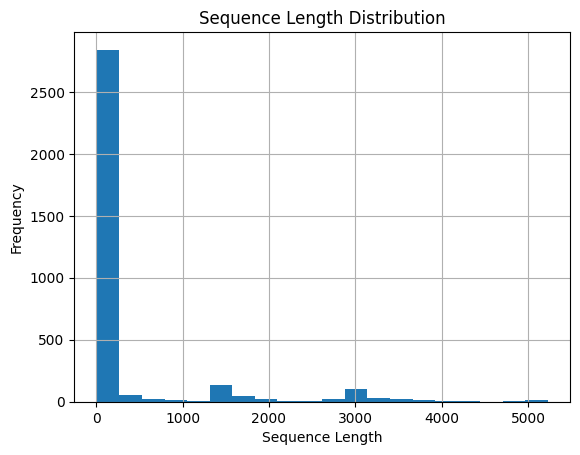

In [7]:
# Length distribution
dataset.seqres_can.map(len).plot.hist(bins=20, grid=True, xlabel="Sequence Length", title="Sequence Length Distribution")

## **Separación**

In [8]:
# Separamos los datos en train y test
# El 20% de los datos para test
data_train, data_test = train_test_split( dataset               # sequence of indexables with same length / shape[0]
                                        , test_size    = 0.2    # represent the proportion of the dataset to include in the test split
                                        , shuffle      = True   # Whether or not to shuffle the data before splitting.
                                        , random_state = 42 )   # Controls the shuffling applied to the data before applying the split.

In [9]:
data_train.shape, data_test.shape

((2688, 2), (673, 2))

In [13]:
print(f"Number of unique RNA types in training set: {data_train.rna_type_cdrna.nunique()}")
print(f"Number of unique RNA types in test set: {data_test.rna_type_cdrna.nunique()}")

Number of unique RNA types in training set: 15
Number of unique RNA types in test set: 15


In [18]:
print(f"Largest RNA sequence in training set: {data_train.seqres_can.map(len).max()}")
print(f"Largest RNA sequence in test set: {data_test.seqres_can.map(len).max()}")

Largest RNA sequence in training set: 5227
Largest RNA sequence in test set: 5070


In [10]:
data_train.rna_type_cdrna.value_counts(dropna=False)

rna_type_cdrna
transcript    1344
rRNA           530
tRNA           287
mRNA           205
riboswitch      95
enzymatic       66
snRNA           38
ncRNA           35
intron          21
SRP_RNA         18
other           15
mixed           10
miRNA            9
piRNA            8
snoRNA           7
Name: count, dtype: int64

In [14]:
data_test.rna_type_cdrna.value_counts(dropna=False)

rna_type_cdrna
transcript    304
rRNA          151
tRNA           79
mRNA           61
riboswitch     33
enzymatic      16
ncRNA           8
snRNA           6
SRP_RNA         3
other           3
intron          3
piRNA           2
mixed           2
snoRNA          1
miRNA           1
Name: count, dtype: int64

### **Secuencias**

#### Convertir secuencias a one-hot encoding

In [ ]:
def one_hot_seq_encode(sequence: str, map_onehot=dict) -> np.ndarray:
    """
    One-hot encodes a sequence using a provided mapping.

    Parameters:

                * sequence (str): The sequence to encode
                * map_onehot (dict): The residue mapping for one-hot encoding (keys are one-letter residues in uppercase, values are lists of 0s and 1s)

    Returns: np.ndarray
    """
    assert isinstance(sequence, str), "Sequence must be a string"
    assert isinstance(map_onehot, dict), "Mapping must be a dictionary"
    assert all(isinstance(v, list) and len(v) == len(map_onehot) for v in map_onehot.values()), "All mapping values must be lists and have the same length"
    assert all(isinstance(i, int) and i in (0, 1) for v in map_onehot.values() for i in v), "All mapping values must be lists of 0s and 1s"
    assert len(sequence) > 0, "Given sequence must not be empty"
    sequence = sequence.upper()
    assert all(r in map_onehot for r in sequence), "All residues must be in the mapping"

    return np.array([map_onehot.get(residue, [0] * len(map_onehot)) for residue in sequence])


In [6]:
# Count types of bases
dataset.seqres_can.str.split('').explode().value_counts(normalize=False, dropna=False).drop(labels=[''])

seqres_can
G    383183
C    303932
A    302107
U    256439
X        36
N        11
I         8
F         3
W         3
M         1
Name: count, dtype: int64

In [7]:
map_onehot = {}
for i, base in enumerate(bases):
    map_onehot[base] = np.zeros(len(bases), dtype=int).tolist()
    map_onehot[base][i] = 1

In [8]:
map_onehot

{'U': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'G': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 'C': [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 'X': [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 'A': [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 'F': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 'N': [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 'W': [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 'I': [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 'M': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]}

In [9]:
len(map_onehot)

10

In [11]:
# Matrix of one-hot encoding using the mapping :)
one_hot_seq_encode(sequence=''.join(map_onehot.keys()), map_onehot=map_onehot)

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

#### Convertir secuencias a embeddings

In [15]:
def embed_sequence(sequence: str, map_residues: dict) -> list[int]:
    """
    Embeds a sequence using a provided mapping.
    If a residue is not found in the mapping, it is replaced with 0.

    Parameters:

        * sequence (str): The sequence to embed
        * map_residues (dict): The residue mapping for embedding (keys are one-letter residues in uppercase, values are embedding vectors)

    Returns: list[int]
    """
    assert isinstance(sequence, str), "Sequence must be a string"
    assert isinstance(map_residues, dict), "Mapping must be a dictionary"
    assert len(sequence) > 0, "Given sequence must not be empty"
    sequence = sequence.upper()

    return [map_residues.get(residue, 0) for residue in sequence]

In [16]:
map_residues = {base: n for n, base in enumerate(bases, 1)}

In [17]:
embed_sequence(sequence=''.join(map_residues.keys()), map_residues=map_residues)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

#### Padding de secuencias

In [80]:
sequences = [
    "AUGCUA",
    "GCUAUGCGAUCGUAGCUA",
    "AUG"
]

sequences_embed = [embed_sequence(seq, map_residues) for seq in sequences]
sequences_onehot = [one_hot_seq_encode(seq, map_onehot) for seq in sequences]

In [81]:
sequences_embed_padded = pad_sequences(sequences_embed, padding='post')
sequences_onehot_padded = pad_sequences(sequences_onehot, padding='post')

In [82]:
print(f"sequences_embed_padded:\n\n{sequences_embed_padded}")

sequences_embed_padded:

[[5 1 2 3 1 5 0 0 0 0 0 0 0 0 0 0 0 0]
 [2 3 1 5 1 2 3 2 5 1 3 2 1 5 2 3 1 5]
 [5 1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [83]:
print(f"sequences_onehot_padded:\n\n{sequences_onehot_padded}")

sequences_onehot_padded:

[[[0 0 0 0 1 0 0 0 0 0]
  [1 0 0 0 0 0 0 0 0 0]
  [0 1 0 0 0 0 0 0 0 0]
  [0 0 1 0 0 0 0 0 0 0]
  [1 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 1 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]]

 [[0 1 0 0 0 0 0 0 0 0]
  [0 0 1 0 0 0 0 0 0 0]
  [1 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 1 0 0 0 0 0]
  [1 0 0 0 0 0 0 0 0 0]
  [0 1 0 0 0 0 0 0 0 0]
  [0 0 1 0 0 0 0 0 0 0]
  [0 1 0 0 0 0 0 0 0 0]
  [0 0 0 0 1 0 0 0 0 0]
  [1 0 0 0 0 0 0 0 0 0]
  [0 0 1 0 0 0 0 0 0 0]
  [0 1 0 0 0 0 0 0 0 0]
  [1 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 1 0 0 0 0 0]
  [0 1 0 0 0 0 0 0 0 0]
  [0 0 1 0 0 0 0 0 0 0]
  [1 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 1 0 0 0 0 0]]

 [[0 0 0 0 1 0 0 0 0 0]
  [1 0 0 0 0 0 0 0 0 0]
  [0 1 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0

Se ve que cuanto más grande la secuencia, el padding para el encoding one-hot es mucho más grande. En este caso, dada una secuencia de largo `L` y `N` la longitud de la secuencia más larga conocida en el dataset, donde `L < N`, entonces el array one-hot de esa secuencia pasa a ser `10xN`.  Para el codificación embedding, el array pasa a ser `LxD`, siendo `D` la dimensión del embedding (en este caso 1).

#### Secuencia más larga como referencia para padding

In [19]:
sequences_embed = [embed_sequence(seq, map_residues) for seq in data_train.seqres_can.unique()]
sequences_embed_padded = pad_sequences(sequences_embed, maxlen=max_length, padding='post', truncating='post')

In [20]:
len(sequences_embed)

2688

In [21]:
print(f"First: {len(sequences_embed[0])}")
print(f"Last: {len(sequences_embed[-1])}")

First: 32
Last: 57


In [22]:
sequences_embed_padded.shape

(2688, 5227)

In [23]:
print(f"First: {len(sequences_embed_padded[0])}")
print(f"Last: {len(sequences_embed_padded[-1])}")

First: 5227
Last: 5227


In [24]:
# analizar la distribución de longitudes para definir un maxlen que cubra, por ejemplo, el 90% de las secuencias sin perder demasiada información
data_train.seqres_can.map(len).describe()

count    2688.000000
mean      364.602307
std       870.062623
min        10.000000
25%        19.000000
50%        41.000000
75%       103.000000
max      5227.000000
Name: seqres_can, dtype: float64

In [25]:
# get upto 90th percentile of distribution of sequence lengths
data_train.seqres_can.map(len).quantile(0.9)

np.float64(1533.0)

In [26]:
# get between 30 upto 90th percentile of distribution of sequence lengths
data_train.seqres_can.map(len).quantile(0.3), data_train.seqres_can.map(len).quantile(0.9)
data_train.loc[(data_train.seqres_can.map(len) >= data_train.seqres_can.map(len).quantile(0.3)) & (data_train.seqres_can.map(len) <= data_train.seqres_can.map(len).quantile(0.9))].shape

(1630, 2)

In [27]:
data_train.loc[data_train.seqres_can.map(len) > 1630].shape


(225, 2)

### **Etiquetas**

#### Codificación categórica: convertir los tipos de RNA (texto) a números
Se muestran 2 formas de hacerlo: una manual y otra utilizando `sklearn`.

##### Utilizando `sklearn`

In [28]:
# Initialize the label encoder
label_encoder = LabelEncoder()
label_encoder.fit(data_train.rna_type_cdrna.tolist())

# Transform the labels
labels = label_encoder.transform(data_train.rna_type_cdrna.tolist())

##### Utilizando `dict` (manual)

In [29]:
# Custom label encoder
data = dataset.rna_type_cdrna.tolist()
classes = sorted(set(data))

class_index = dict(zip(classes, range(len(classes))))
index_class = dict(zip(range(len(classes)), classes))
labels = list(map(class_index.get, data_train.rna_type_cdrna.tolist()))

In [30]:
class_index

{'SRP_RNA': 0,
 'enzymatic': 1,
 'intron': 2,
 'mRNA': 3,
 'miRNA': 4,
 'mixed': 5,
 'ncRNA': 6,
 'other': 7,
 'piRNA': 8,
 'rRNA': 9,
 'riboswitch': 10,
 'snRNA': 11,
 'snoRNA': 12,
 'tRNA': 13,
 'transcript': 14}

In [31]:
index_class

{0: 'SRP_RNA',
 1: 'enzymatic',
 2: 'intron',
 3: 'mRNA',
 4: 'miRNA',
 5: 'mixed',
 6: 'ncRNA',
 7: 'other',
 8: 'piRNA',
 9: 'rRNA',
 10: 'riboswitch',
 11: 'snRNA',
 12: 'snoRNA',
 13: 'tRNA',
 14: 'transcript'}

In [32]:
# Get key with value '4'
print({k: v for k, v in class_index.items() if v == 4}) # Dificil. Usa un bucle y es lento

# Get value of key '4'
print(index_class[4])  # Super fácil y rápido. Usa un poquito de memoria porque requiere definir un dict extra

# Map the encoded labels back to the original labels
print(label_encoder.inverse_transform([4])) # Fácil pero requiere sklearn y es una lista con único elemento

{'miRNA': 4}
miRNA
['miRNA']


### **Balanceo de clases**

Existen 15 tipos de RNA en el dataset y están fuertemente desbalanceados.
Queremos que no haya un bias a los tipos mayoritarios, por lo que vamos a usar pesos de clase para balancear el aprendizaje en el entrenamiento.

In [33]:
# Pesos de las clases
# https://datascience.stackexchange.com/a/18722
class_weights  =  compute_class_weight( class_weight ='balanced'
                                    ,   classes      = np.unique(labels)
                                    ,   y            = labels )

In [34]:
class_weight_dict = dict(enumerate(class_weights))

# **Creación del modelo**

### **Arquitectura**

In [35]:
vocab_size   = len(map_residues) + 1   # +1 para el padding (0)
input_length = max_length              # Longitud máxima de las secuencias de entrada
nb_classes   = len(classes)            # Número de clases de salida

In [84]:
# Inicialización del modelo
if 'model' in locals():
    del model

model = Sequential(name="RNA_Type_Classifier")

# Capa de entrada que define la forma de los datos de entrada
model.add(Input(shape=(input_length,), dtype=tf.int32))

# Capa Embedding: https://keras.io/api/layers/core_layers/embedding/
# CUIDADO: documentación oficial está desactualizada:
# - https://github.com/keras-team/keras/issues/19282
# - No existe más el parámetro 'input_length'
# Solución: ahora se infiere: https://github.com/keras-team/keras/issues/19094#issuecomment-1909387912
# , input_length           = input_length   # Longitud máxima de las secuencias de entrada
model.add(Embedding(  input_dim              = vocab_size     # Dimensión del vocabulario (número de tokens únicos + 1 por el padding)
                    , output_dim             = 64             # Dimensión del embedding (ajustable). Se fija en 64 porque el vocabulario es pequeño y no se necesita un embedding muy grande. Además ayuda a no consumir tanta memoria.
                    , mask_zero              = True           # Capas que puedan ignorar el 0 por padding
                    , embeddings_initializer = 'uniform'      # Por defecto: inicialización uniforme de los pesos del embedding
                    , name                   = 'embedding_layer' ))
# Cada lote de N secuencias tiene forma (N, input_length, 64 embeddings) y se aplana a (N, input_length * 64)
# model.add(Flatten(name="flatten_layer"))
model.add(Flatten(name="flatten_layer"))

# Normalización por lotes después de la capa de embedding + aplanamiento
model.add(BatchNormalization(name="batch_norm_1"))

# Feed-forward - Capa oculta
# Cantidad de hiperparámetros por lote de N:
# (N * input_length * 64) * 128 + 128 (bias) = (N * 45495808) + 128 = (N * 45495936)
# Si N es total, N=3361, son 152.911.840.896 parámetros
# Si N=32, son 1.455.869.952 parámetros por lote.
# Si N=16, son 727.934.976 parámetros por lote.
model.add(Dense(units=128, activation='relu', kernel_initializer='he_uniform', name="dense_1"))

# Normalización por lotes después de la capa oculta
model.add(BatchNormalization(name="batch_norm_2"))

# Capa de salida usando softmax
# Tiene tantas neuronas como clases espero
model.add(Dense(units=nb_classes, activation='softmax', name="output_layer"))


/home/martingb/Projects/2025/rna_classifier/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'flatten_layer' (of type Flatten) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


#### Optimizador

In [85]:
# API : https://keras.io/api/optimizers/
# learning_rate es el 'alpha'
alpha = 0.001 # Valor por defecto en Adam
opt = keras.optimizers.Adam(learning_rate=alpha) # ADAM = AdaGrad + Momentum

#### Métricas

In [114]:
# Accuracy metrics
# Accuracy : https://keras.io/api/metrics/accuracy_metrics/#accuracy-class

# Classification metrics based on True/False positives & negatives
# F1 : https://keras.io/api/metrics/classification_metrics/#f1score-class

# Metrics for each class
metrics = [ keras.metrics.SparseCategoricalAccuracy(name='accuracy') ]

# metrics.extend([
#     # Precision and Recall for each class
#     keras.metrics.Precision(class_id=class_id, name=f'precision_class_{class_id}_{index_class[class_id].replace(" ", "_")}')
#     for class_id in class_index.values()
# ] + [
#     keras.metrics.Recall(class_id=class_id, name=f'recall_class_{class_id}_{index_class[class_id].replace(" ", "_")}')
#     for class_id in class_index.values()
# ])


In [115]:
metrics

[<SparseCategoricalAccuracy name=accuracy>]

### **Compilación**

In [116]:
model.compile( loss      = 'sparse_categorical_crossentropy' # Función de pérdida para codificación categórica de enteros
            ,  optimizer = opt                               # Usa el optimizador Adam con valores por defecto. Podría haberse usado 'adam' directamente
            ,  metrics   = metrics )

### **Monitoreo**

In [111]:
# Callbacks
# https://keras.io/api/callbacks/early_stopping/#earlystopping-class
early_stopping = EarlyStopping( monitor              = 'val_loss' # Quantity to be monitored. (default: 'val_loss')
                            ,   verbose              = 1          # Verbosity mode, 0 or 1. Mode 0 is silent, and mode 1 displays messages when the callback takes an action. Defaults to 0.
                            ,   patience             = 3          # Number of epochs with no improvement after which training will be stopped
                            ,   restore_best_weights = True       # Whether to restore model weights from the epoch with the best value of the monitored quantity.
                            ,   min_delta            = 0.001 )    # Minimum change in the monitored quantity to qualify as an improvement

callbacks = [early_stopping]

### **Resumen del modelo**

In [112]:
model.summary()

Model: "RNA_Type_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ (None, 5227, 64)       │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_layer (Flatten)         │ (None, 334528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_1                    │ (None, 334528)         │     1,338,112 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │    42,819,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_2                    │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131,144,303 (500.28 MB)

 Trainable params: 43,491,663 (165.91 MB)

 Non-trainable params: 669,312 (2.55 MB)

 Optimizer params: 86,983,328 (331.82 MB)

### **Entrenamiento**

#### Uso de lotes (batches)

In [113]:
history  =  model.fit( x                = sequences_embed_padded # Secuencias con padding para entrenamiento
                    ,  y                = np.array(labels)            # Etiquetas para entrenamiento
                    ,  batch_size       = 32                     # Tamaño del lote de entrenamiento. Esto es arbitrario. Uso 32 secuencias para cada lote por motivos de memoria y rendimiento.
                    ,  epochs           = 30                     # Número de épocas
                    ,  verbose          = True                   # Verbosidad del entrenamiento
                    ,  validation_split = 0.2                    # Proporción de datos para validación
                    ,  class_weight     = class_weight_dict      # Diccionario de balanceo (sección 'Balanceo de clases')
                    ,  callbacks        = callbacks )            # Lista de callbacks para monitoreo del entrenamiento


Epoch 1/30


/home/martingb/Projects/2025/rna_classifier/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'flatten_layer' (of type Flatten) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


67/68 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7557 - loss: 0.2699 - precision_class_0_SRP_RNA: 0.9851 - precision_class_10_riboswitch: 0.9802 - precision_class_11_snRNA: 1.0000 - precision_class_12_snoRNA: 0.8604 - precision_class_13_tRNA: 1.0000 - precision_class_14_transcript: 0.9949 - precision_class_1_enzymatic: 1.0000 - precision_class_2_intron: 1.0000 - precision_class_3_mRNA: 1.0000 - precision_class_4_miRNA: 0.9104 - precision_class_5_mixed: 0.8955 - precision_class_6_ncRNA: 0.9204 - precision_class_7_other: 0.9851 - precision_class_8_piRNA: 0.9851 - precision_class_9_rRNA: 0.9957 - recall_class_0_SRP_RNA: 0.0076 - recall_class_10_riboswitch: 0.0366 - recall_class_11_snRNA: 0.0195 - recall_class_12_snoRNA: 0.0042 - recall_class_13_tRNA: 0.0960 - recall_class_14_transcript: 0.2354 - recall_class_1_enzymatic: 0.0401 - recall_class_2_intron: 0.0117 - recall_class_3_mRNA: 0.0900 - recall_class_4_miRNA: 0.0089 - recall_class_5_mixed: 0.0025 - recall_class_6_ncRNA: 0.0120 - r

InvalidArgumentError: Graph execution error:

Detected at node strided_slice_21 defined at (most recent call last):
<stack traces unavailable>
slice index 6 of dimension 0 out of bounds.

Stack trace for op definition: 
File "<frozen runpy>", line 198, in _run_module_as_main
File "<frozen runpy>", line 88, in _run_code
File "/home/martingb/Projects/2025/rna_classifier/.venv/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
File "/home/martingb/Projects/2025/rna_classifier/.venv/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
File "/home/martingb/Projects/2025/rna_classifier/.venv/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start
File "/home/martingb/Projects/2025/rna_classifier/.venv/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 211, in start
File "/home/martingb/.local/share/uv/python/cpython-3.12.11-linux-x86_64-gnu/lib/python3.12/asyncio/base_events.py", line 645, in run_forever
File "/home/martingb/.local/share/uv/python/cpython-3.12.11-linux-x86_64-gnu/lib/python3.12/asyncio/base_events.py", line 1999, in _run_once
File "/home/martingb/.local/share/uv/python/cpython-3.12.11-linux-x86_64-gnu/lib/python3.12/asyncio/events.py", line 88, in _run
File "/home/martingb/Projects/2025/rna_classifier/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 519, in dispatch_queue
File "/home/martingb/Projects/2025/rna_classifier/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 508, in process_one
File "/home/martingb/Projects/2025/rna_classifier/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 400, in dispatch_shell
File "/home/martingb/Projects/2025/rna_classifier/.venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 368, in execute_request
File "/home/martingb/Projects/2025/rna_classifier/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 767, in execute_request
File "/home/martingb/Projects/2025/rna_classifier/.venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 455, in do_execute
File "/home/martingb/Projects/2025/rna_classifier/.venv/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 577, in run_cell
File "/home/martingb/Projects/2025/rna_classifier/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3116, in run_cell
File "/home/martingb/Projects/2025/rna_classifier/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3171, in _run_cell
File "/home/martingb/Projects/2025/rna_classifier/.venv/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner
File "/home/martingb/Projects/2025/rna_classifier/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3394, in run_cell_async
File "/home/martingb/Projects/2025/rna_classifier/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3639, in run_ast_nodes
File "/home/martingb/Projects/2025/rna_classifier/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3699, in run_code
File "/tmp/ipykernel_3276855/2693328805.py", line 1, in <module>
File "/home/martingb/Projects/2025/rna_classifier/.venv/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/home/martingb/Projects/2025/rna_classifier/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 377, in fit
File "/home/martingb/Projects/2025/rna_classifier/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 220, in function
File "/home/martingb/Projects/2025/rna_classifier/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 133, in multi_step_on_iterator
File "/home/martingb/Projects/2025/rna_classifier/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 114, in one_step_on_data
File "/home/martingb/Projects/2025/rna_classifier/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 85, in train_step
File "/home/martingb/Projects/2025/rna_classifier/.venv/lib/python3.12/site-packages/keras/src/trainers/trainer.py", line 490, in compute_metrics
File "/home/martingb/Projects/2025/rna_classifier/.venv/lib/python3.12/site-packages/keras/src/trainers/compile_utils.py", line 334, in update_state
File "/home/martingb/Projects/2025/rna_classifier/.venv/lib/python3.12/site-packages/keras/src/trainers/compile_utils.py", line 21, in update_state
File "/home/martingb/Projects/2025/rna_classifier/.venv/lib/python3.12/site-packages/keras/src/metrics/confusion_metrics.py", line 378, in update_state
File "/home/martingb/Projects/2025/rna_classifier/.venv/lib/python3.12/site-packages/keras/src/metrics/metrics_utils.py", line 480, in update_confusion_matrix_variables

	 [[{{node strided_slice_21}}]]
	tf2xla conversion failed while converting __inference_one_step_on_data_88089[]. Run with TF_DUMP_GRAPH_PREFIX=/path/to/dump/dir and --vmodule=xla_compiler=2 to obtain a dump of the compiled functions.
	 [[StatefulPartitionedCall]] [Op:__inference_multi_step_on_iterator_88318]

### **Evaluación**

In [106]:
history.history['accuracy']

[0.5446511507034302,
 0.5144186019897461,
 0.5106976628303528,
 0.5837209224700928,
 0.5841860175132751,
 0.6190697550773621,
 0.6297674179077148,
 0.630232572555542,
 0.6930232644081116,
 0.6958139538764954]

### **Predicción**

result = model.predict(...)

# **Almacenamiento del modelo**

Documentación oficial:
- https://keras.io/guides/serialization_and_saving/
- https://keras.io/api/models/model_saving_apis/model_saving_and_loading/#whole-model-saving-amp-loading

Keras soporta el formato HDF5 para guardar modelos completos. También soporta el formato 'tf' (TensorFlow SavedModel)  
HDF5 es un formato de archivo que permite almacenar grandes cantidades de datos de manera eficiente.  

Un archivo HDF5 contiene:
- Los pesos del modelo.
- La arquitectura del modelo, permitiendo recrear el modelo.

### Almacenamiento del modelo

In [ ]:
from datetime import datetime
# Time format: YYYYMMDD-HHMMSS
dt = datetime.now().strftime("%Y%m%d-%H%M%S")

model.save(filepath    = f"{dt}_rna_classifier_model.keras"
        ,  save_format = 'h5'
        ,  zipped      = True       # Whether to save the model as a zipped .keras archive (default when saving locally), or as an unzipped directory (default when saving on the Hugging Face Hub).
        ,  overwrite   = True )

### Almacenamiento de pesos

In [ ]:
# https://keras.io/api/models/model_saving_apis/weights_saving_and_loading/#saveweights-method
model.save_weights(filepath       = f"{dt}_rna_classifier_model_weights.h5"
                ,  overwrite      = True
                ,  max_shard_size = None)       # If not None, the weights will be saved in multiple shards of up to max_shard_size GB each.

### Almacenamiento de arquitectura

In [ ]:
with open(f"{dt}_rna_classifier_model_architecture.json", "w") as json_file:
    json_file.write(model.to_json())

# **Recupero del modelo**

### Recupero de arquitectura

In [ ]:
# Loads a model saved via model.save()
# https://keras.io/api/models/model_saving_apis/model_saving_and_loading/#loadmodel-function
model = keras.saving.load_model(...)

### Recupero de pesos

In [ ]:
# https://keras.io/api/models/model_saving_apis/weights_saving_and_loading/#load_weights-method
# NOte: Sharding
# When loading sharded weights, it is important to specify filepath that ends with *.weights.json
# which is used as the configuration file. Additionally, the sharded files *_xxxxx.weights.h5 must
# be in the same directory as the configuration file.

Model.load_weights(filepath      = f"{dt}_rna_classifier_model_weights.h5"
                ,  skip_mismatch = False )